CNN

In [2]:
pip install scikit-learn

   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/8.9 MB 11.2 MB/s eta 0:00:01
   --------------------- ------------------ 4.7/8.9 MB 14.2 MB/s eta 0:00:01
   ------------------------ --------------- 5.5/8.9 MB 10.2 MB/s eta 0:00:01
   ------------------------- -------------- 5.8/8.9 MB 8.8 MB/s eta 0:00:01
   ------------------------------ --------- 6.8/8.9 MB 7.5 MB/s eta 0:00:01
   ---------------------------------- ----- 7.6/8.9 MB 6.6 MB/s eta 0:00:01
   ------------------------------------- -- 8.4/8.9 MB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 5.9 MB/s eta 0:00:00

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# -------------------------
# Config
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

img_size = (512, 512)
batch_size = 16
num_epochs = 15
learning_rate = 1e-4

# -------------------------
# Custom Dataset Class
# -------------------------
class LeafDataset(Dataset):
    def __init__(self, base_dir, transform=None, label_map=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.label_map = label_map or {}

        classes = sorted(os.listdir(base_dir))
        if not self.label_map:
            self.label_map = {cls_name: idx for idx, cls_name in enumerate(classes)}

        for cls in classes:
            cls_folder = os.path.join(base_dir, cls)
            if not os.path.isdir(cls_folder):
                continue
            for fname in os.listdir(cls_folder):
                if fname.endswith(('.jpg', '.png', '.jpeg')):
                    self.image_paths.append(os.path.join(cls_folder, fname))
                    self.labels.append(self.label_map[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# -------------------------
# Transforms
# -------------------------
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -------------------------
# Load Data
# -------------------------
train_dir = r"E:\Github repos\Rice-Disease-Simulation\data\train"
val_dir = r"E:\Github repos\Rice-Disease-Simulation\data\validation"

train_dataset = LeafDataset(train_dir, transform=transform)
val_dataset = LeafDataset(val_dir, transform=transform, label_map=train_dataset.label_map)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# -------------------------
# CNN Model
# -------------------------
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 512 -> 256
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 256 -> 128
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 128 -> 64
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),# 64 -> 32
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),# 32 -> 16
            nn.Flatten(),  # 512 * 16 * 16 = 131072
            nn.Linear(512 * 16 * 16, 512), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = CNNModel(num_classes=len(train_dataset.label_map)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -------------------------
# Training Loop
# -------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    print(f"✅ Epoch {epoch + 1}/{num_epochs} - Avg Loss: {avg_loss:.4f}")

# -------------------------
# Evaluation
# -------------------------
model.eval()
all_preds, all_labels = [], []

print("\n🔍 Running validation...")
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n✅ Classification Report:")
print(classification_report(all_labels, all_preds, target_names=list(train_dataset.label_map.keys())))

print("✅ Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Device: cuda


✅ Epoch 1/15 - Avg Loss: 1.1341


✅ Epoch 2/15 - Avg Loss: 0.7351


✅ Epoch 3/15 - Avg Loss: 0.6214


✅ Epoch 4/15 - Avg Loss: 0.5030


✅ Epoch 5/15 - Avg Loss: 0.4467


✅ Epoch 6/15 - Avg Loss: 0.3518


✅ Epoch 7/15 - Avg Loss: 0.3036


✅ Epoch 8/15 - Avg Loss: 0.2854


✅ Epoch 9/15 - Avg Loss: 0.2446


✅ Epoch 10/15 - Avg Loss: 0.1909


✅ Epoch 11/15 - Avg Loss: 0.1948


✅ Epoch 12/15 - Avg Loss: 0.1258


✅ Epoch 13/15 - Avg Loss: 0.1232


✅ Epoch 14/15 - Avg Loss: 0.1004


✅ Epoch 15/15 - Avg Loss: 0.0744

🔍 Running validation...


Evaluating: 100%|██████████| 28/28 [00:10<00:00,  2.76it/s]


✅ Classification Report:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.65      0.79      0.71        19
           brown_spot       0.87      0.82      0.84        76
              healthy       0.90      0.90      0.90        88
           leaf_blast       0.81      0.77      0.79        88
           leaf_scald       0.98      0.99      0.98        88
    narrow_brown_spot       0.95      0.99      0.97        88

             accuracy                           0.89       447
            macro avg       0.86      0.88      0.87       447
         weighted avg       0.89      0.89      0.89       447

✅ Confusion Matrix:
[[15  3  0  0  1  0]
 [ 2 62  1  7  0  4]
 [ 0  0 79  9  0  0]
 [ 5  5  8 68  1  1]
 [ 1  0  0  0 87  0]
 [ 0  1  0  0  0 87]]


## Grad-CAM

In [4]:
pip install grad-cam

     ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
     -------- ------------------------------- 1.6/7.8 MB 11.9 MB/s eta 0:00:01
     --------------------- ------------------ 4.2/7.8 MB 16.7 MB/s eta 0:00:01
     --------------------- ------------------ 4.2/7.8 MB 16.7 MB/s eta 0:00:01
     --------------------- ------------------ 4.2/7.8 MB 16.7 MB/s eta 0:00:01
     --------------------- ------------------ 4.2/7.8 MB 16.7 MB/s eta 0:00:01
     ------------------------------------- -- 7.3/7.8 MB 6.2 MB/s eta 0:00:01
     ---------------------------------------- 7.8/7.8 MB 6.4 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for grad-cam: filename=grad_cam-

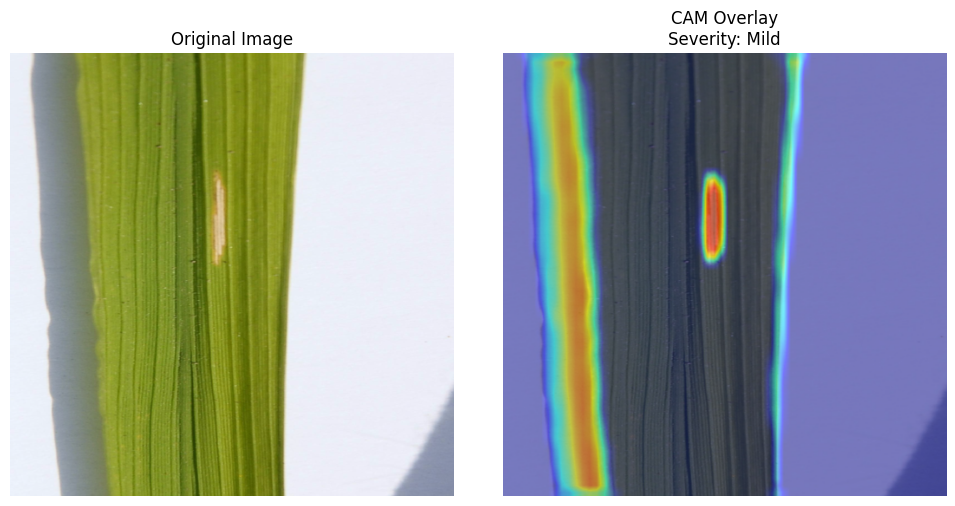

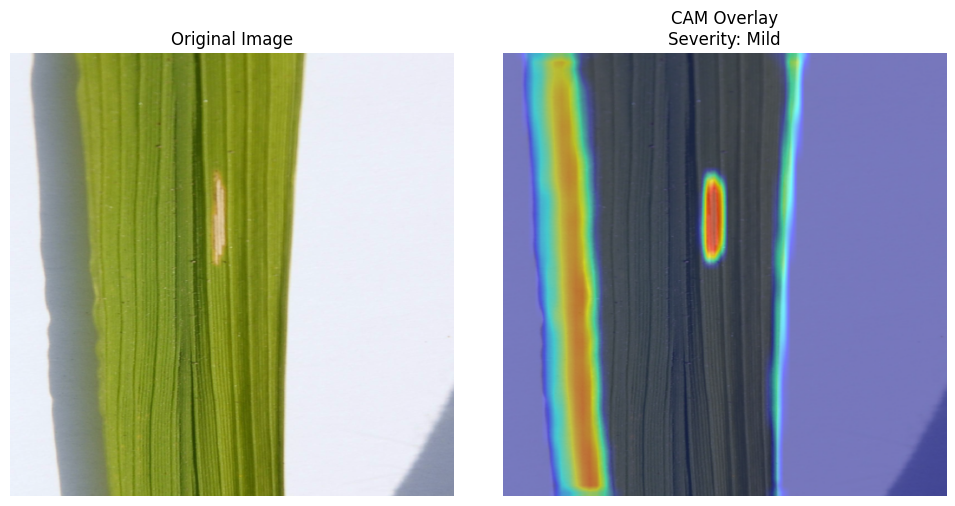

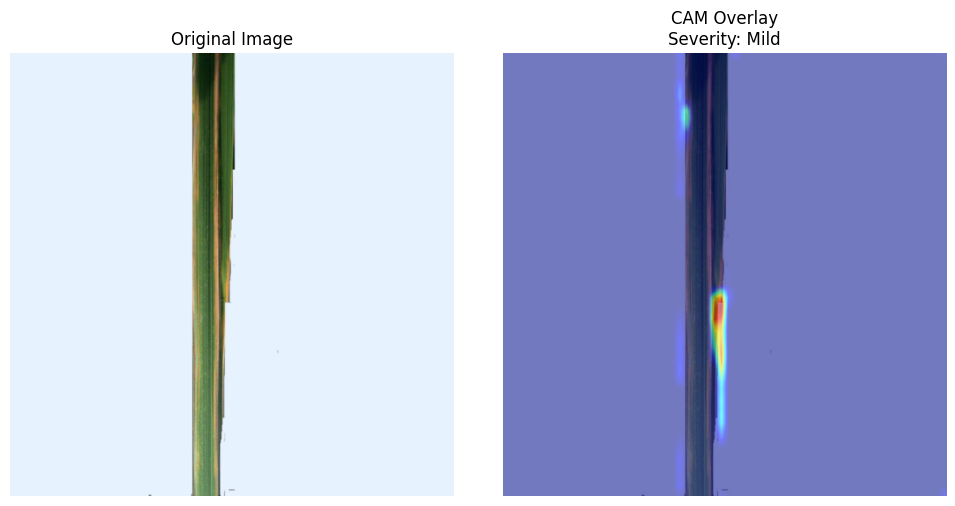

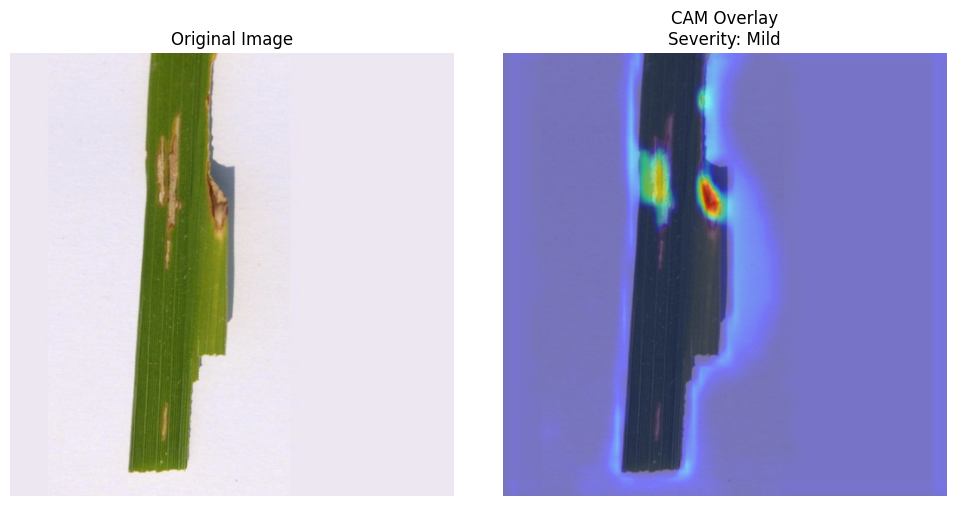

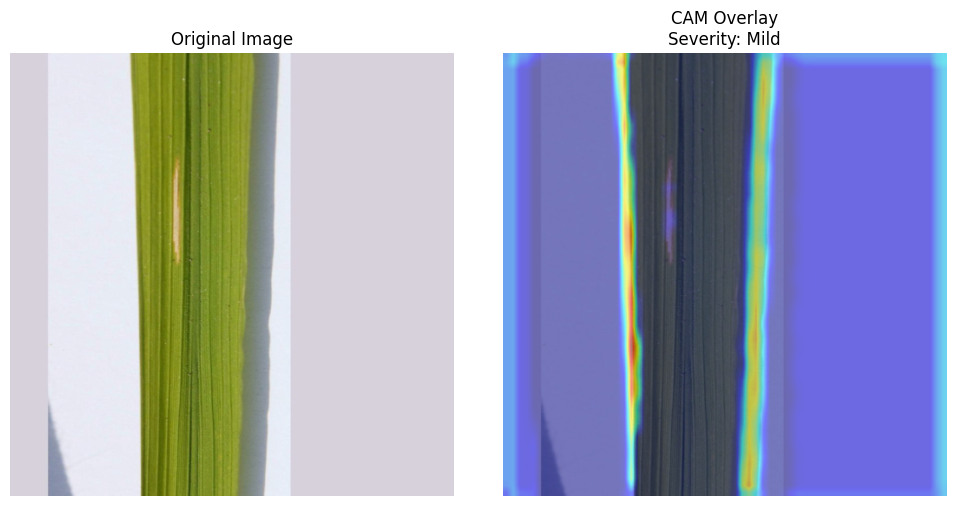

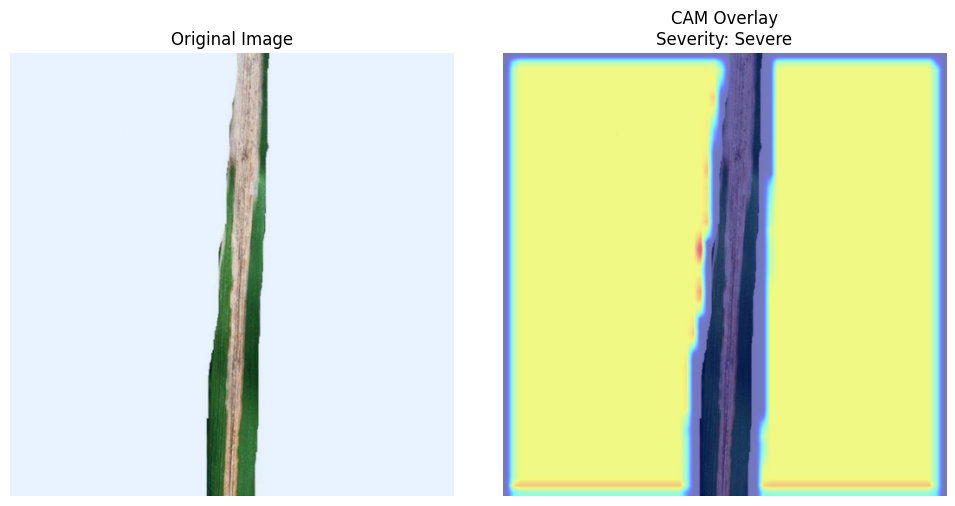

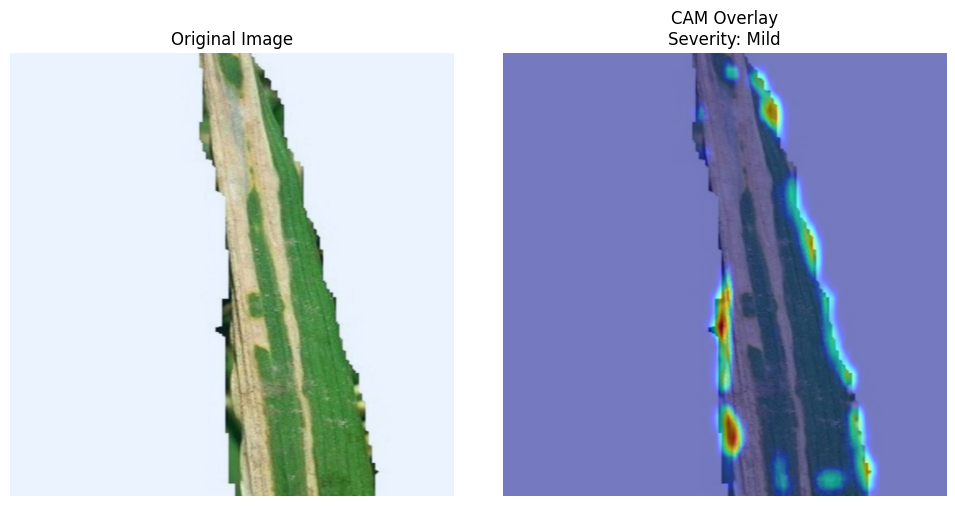

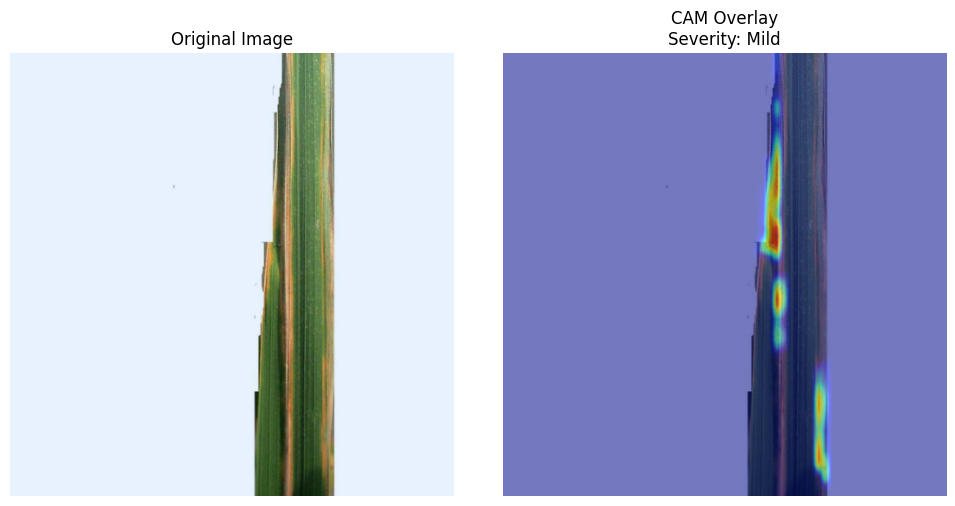

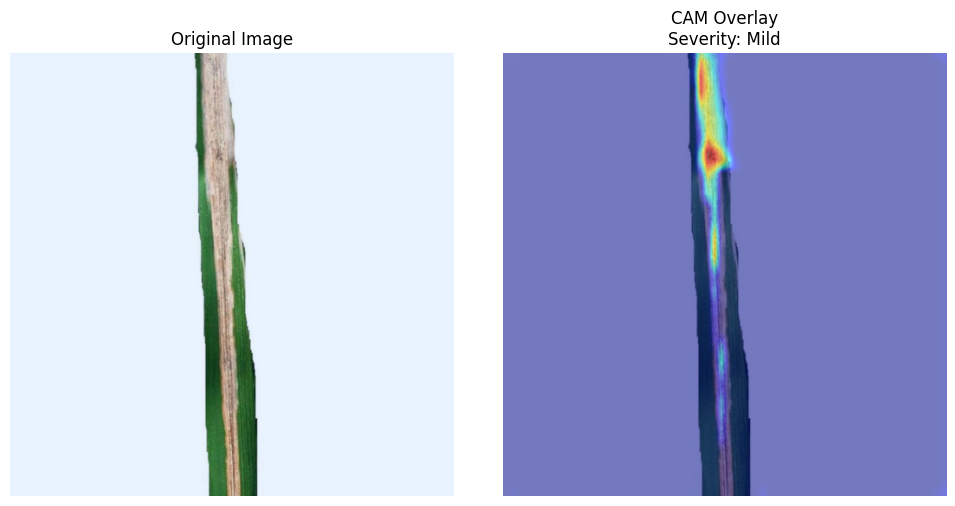

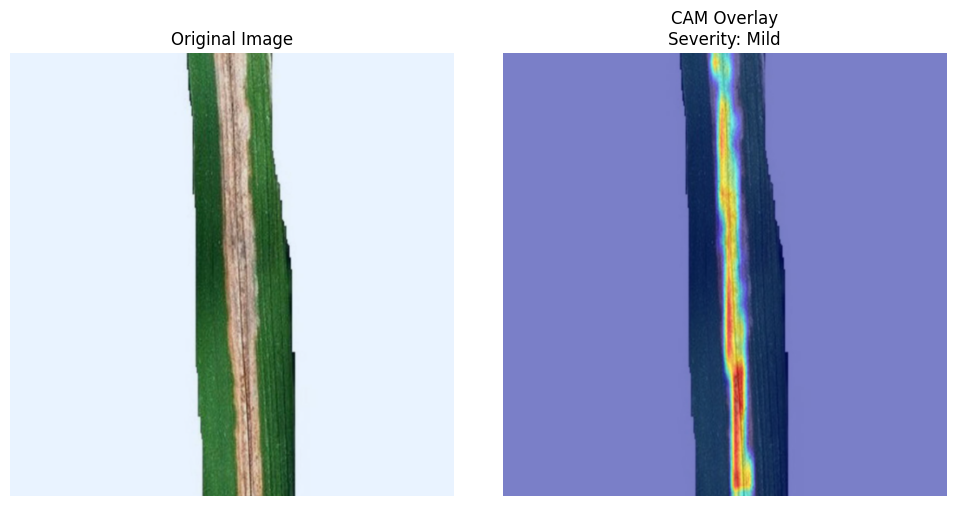

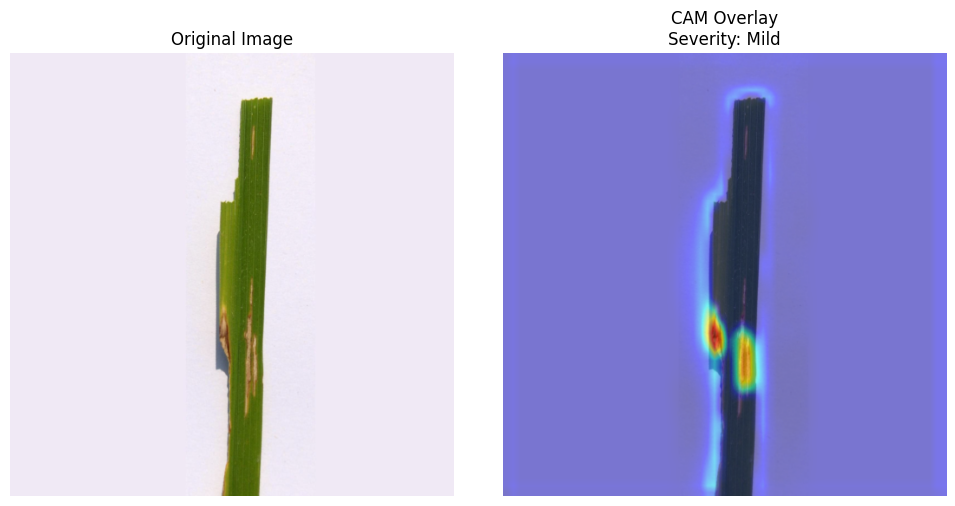

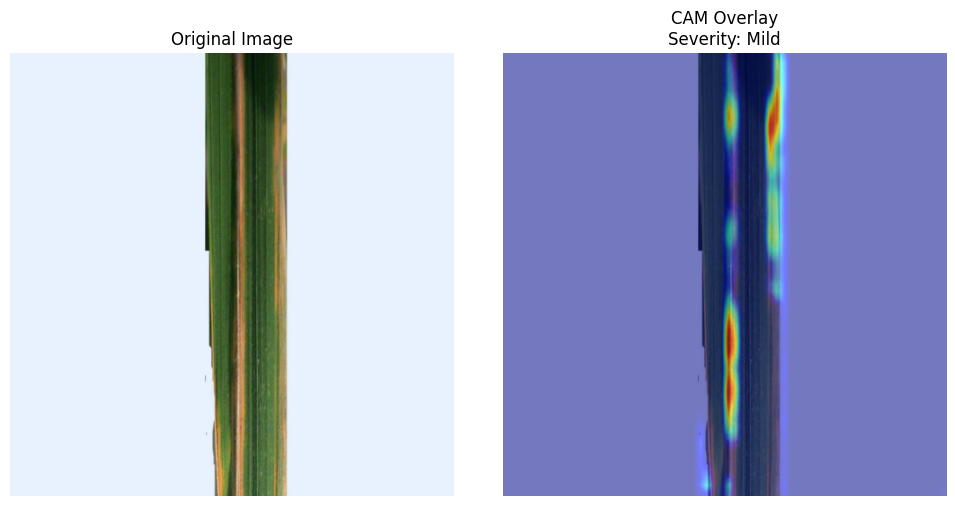

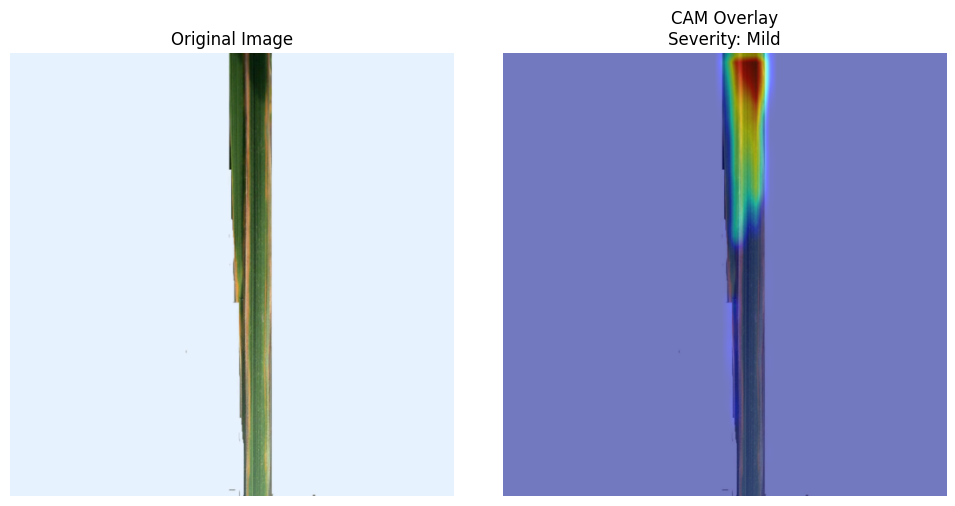

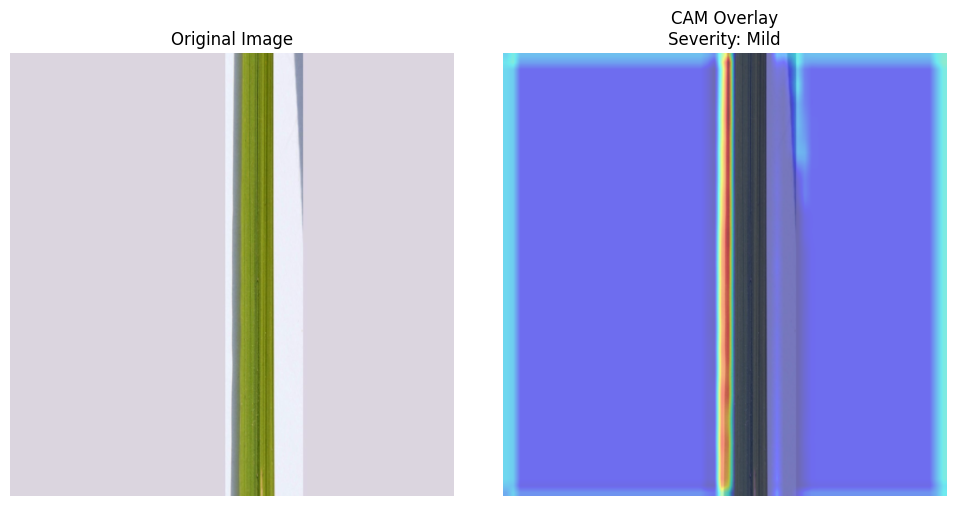

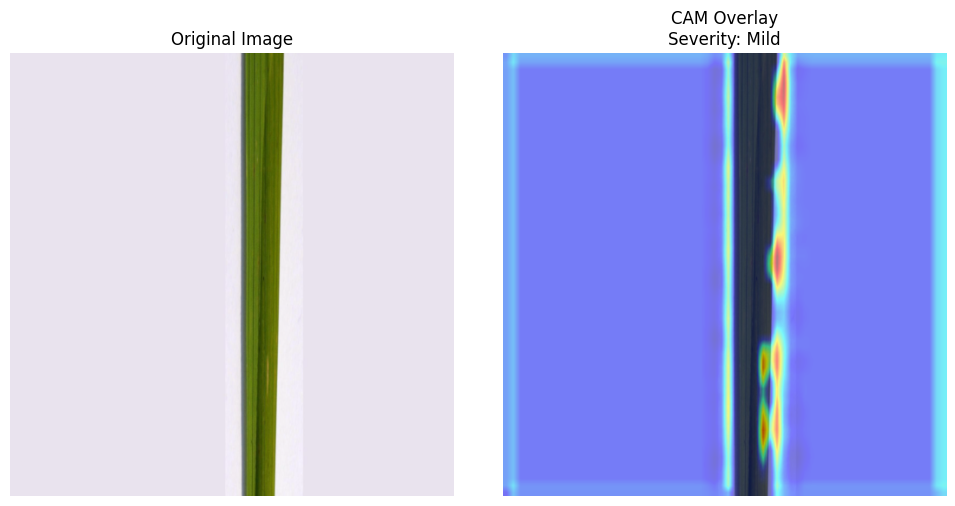

In [10]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# -------------------------
# Helper: Compute Severity
# -------------------------
def compute_severity(cam_map: np.ndarray, threshold: float = 0.3) -> str:
    """
    Estimate severity based on percentage of high-activation pixels in CAM.
    """
    cam_map = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min())
    severe_area_ratio = np.sum(cam_map > threshold) / cam_map.size

    if severe_area_ratio < 0.2:
        return "Mild"
    elif severe_area_ratio < 0.5:
        return "Moderate"
    else:
        return "Severe"

# -------------------------
# Grad-CAM Setup
# -------------------------
target_layer = model.net[10]  # Adjust if needed (last Conv2d layer)
cam = GradCAM(model=model, target_layers=[target_layer]) # , use_cuda=torch.cuda.is_available())

model.eval()
count = 0

# -------------------------
# Show Original + CAM Overlay
# -------------------------
for images, labels in val_loader:
    images = images.to(device)
    for i in range(images.size(0)):
        input_tensor = images[i].unsqueeze(0)

        # Get Grad-CAM
        grayscale_cam = cam(input_tensor=input_tensor)[0]

        # Get image as numpy (original)
        image_np = input_tensor[0].cpu().permute(1, 2, 0).numpy()
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize

        # Get CAM overlay
        cam_overlay = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

        # Estimate severity
        severity = compute_severity(grayscale_cam)

        # Plot original and CAM side-by-side
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].imshow(image_np)
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(cam_overlay)
        axs[1].set_title(f"CAM Overlay\nSeverity: {severity}")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

        count += 1
        if count == 15:  # Show only 5 images
            break
    break


In [ ]:
pip install torchcam

In [ ]:
from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

In [17]:
target_layer = model.net[3]  # The earlier Conv2d(32, 64, ...)
cam_extractor = GradCAM(model, target_layer=target_layer)

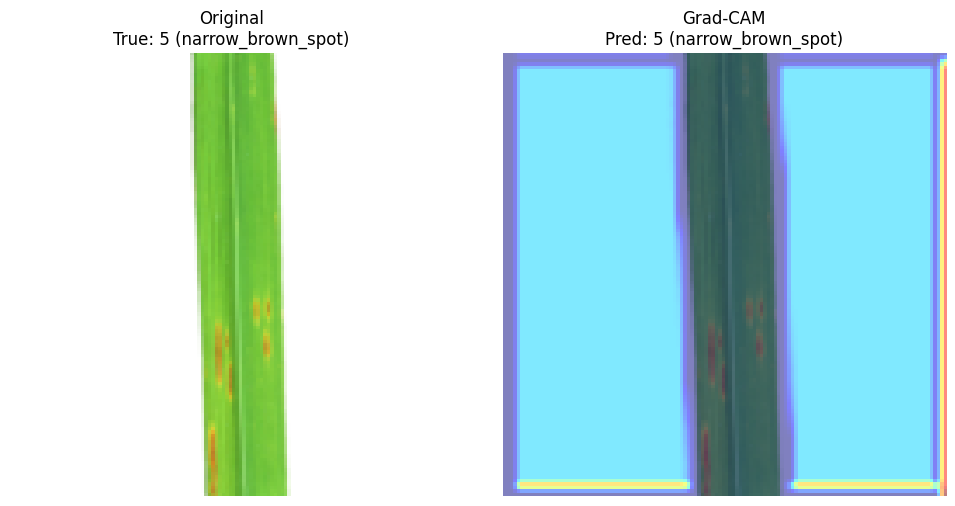

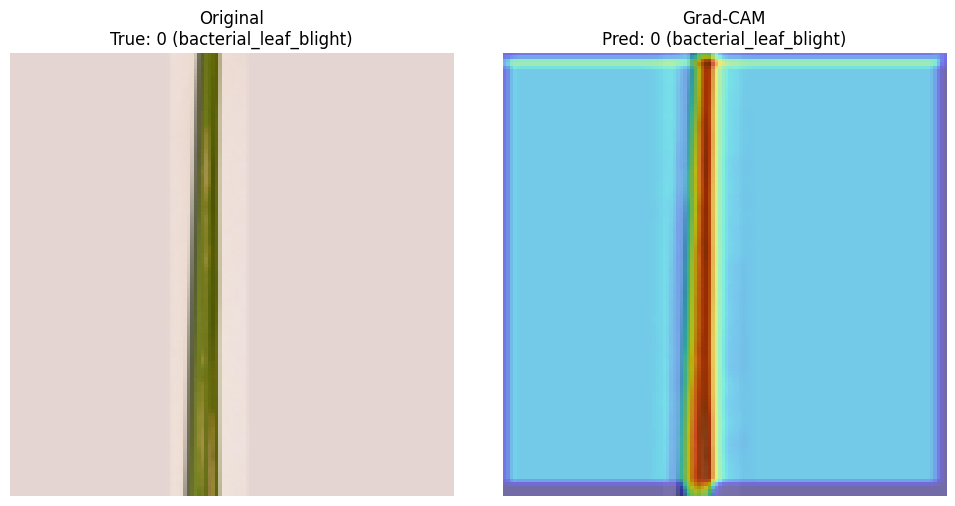

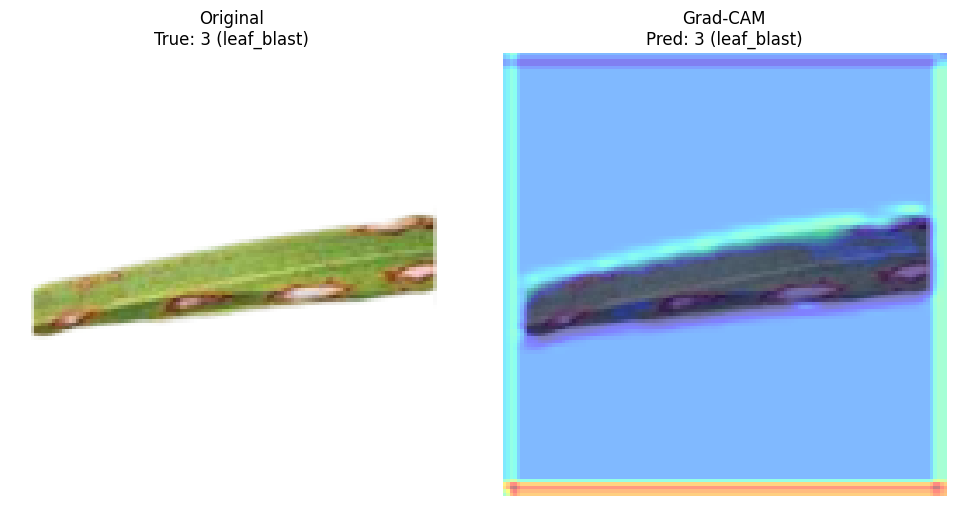

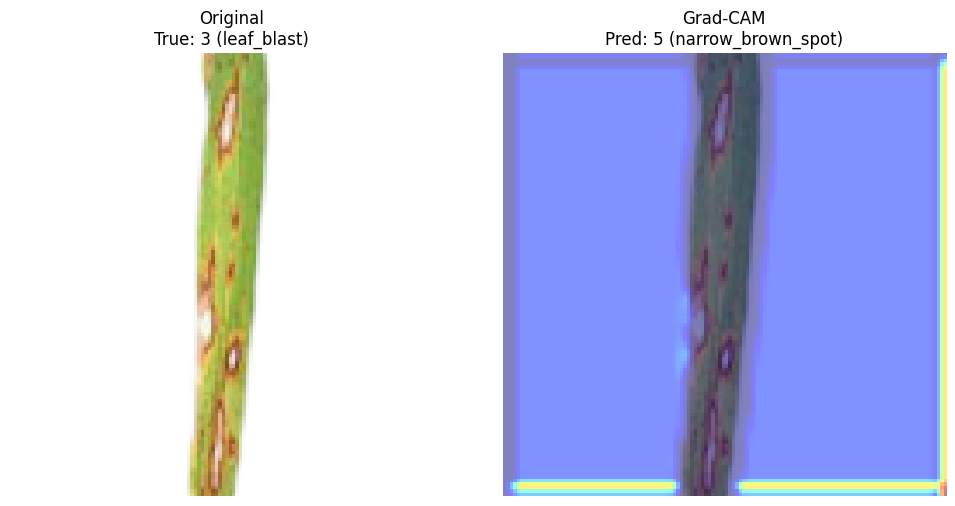

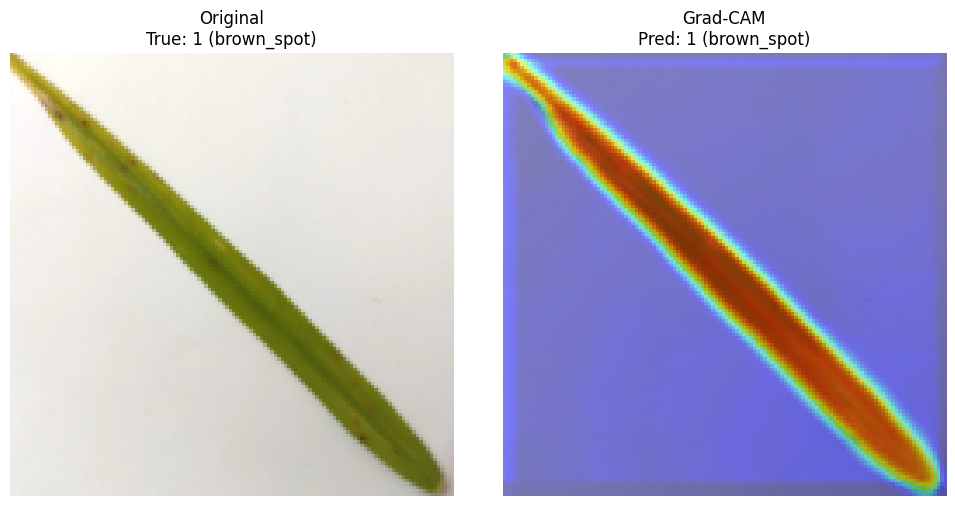

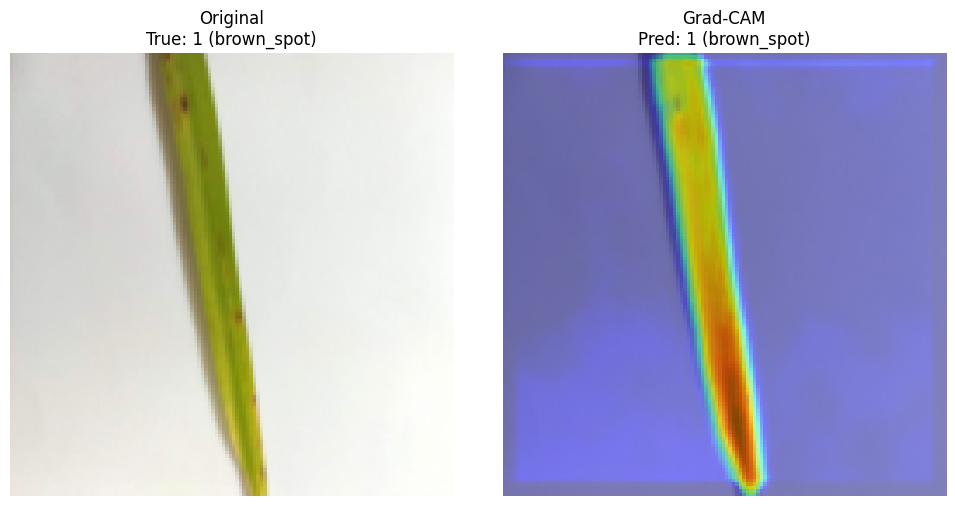

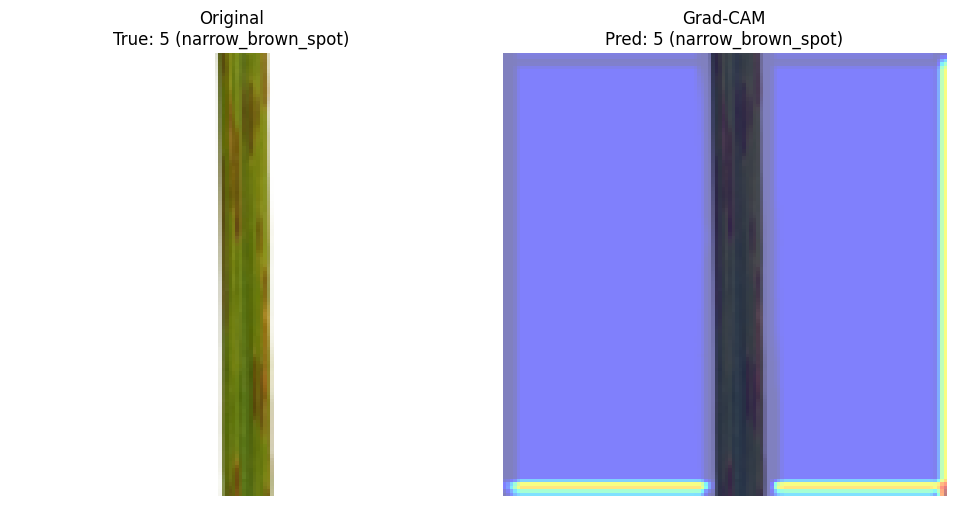

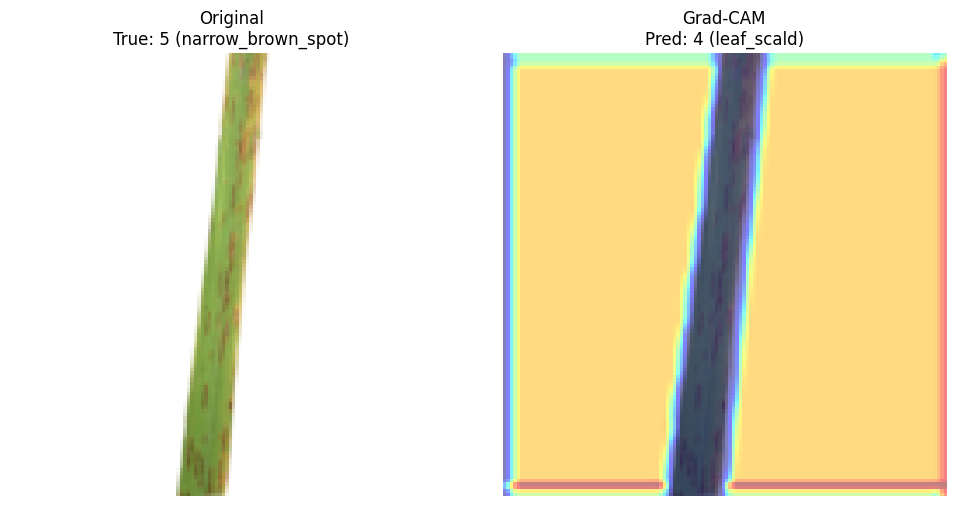

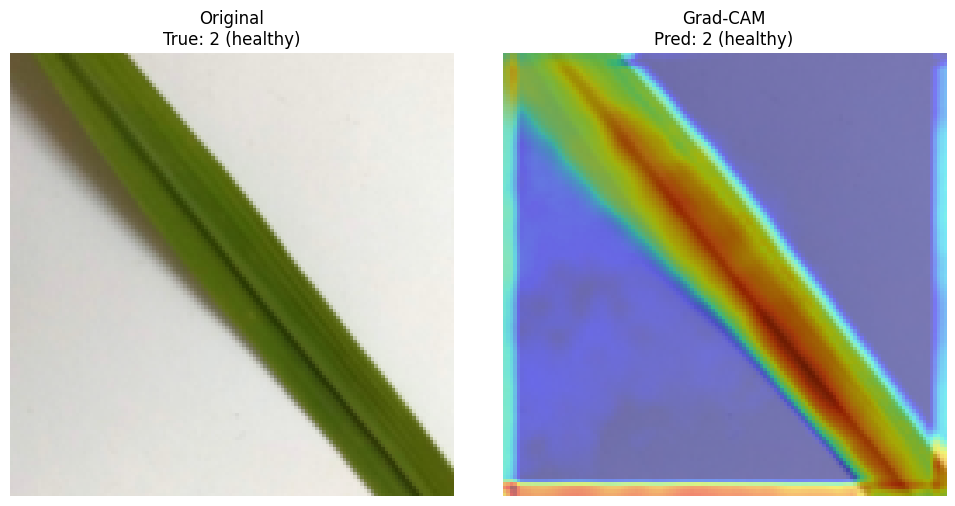

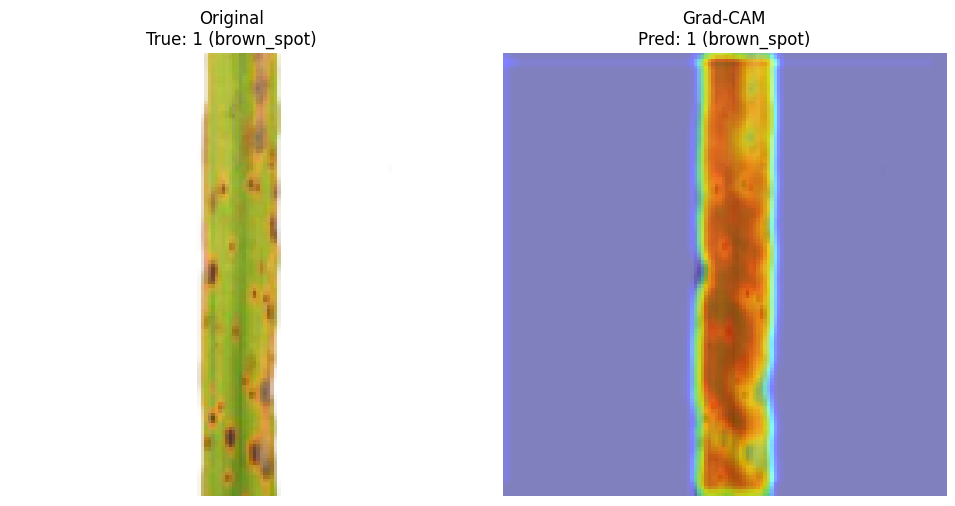

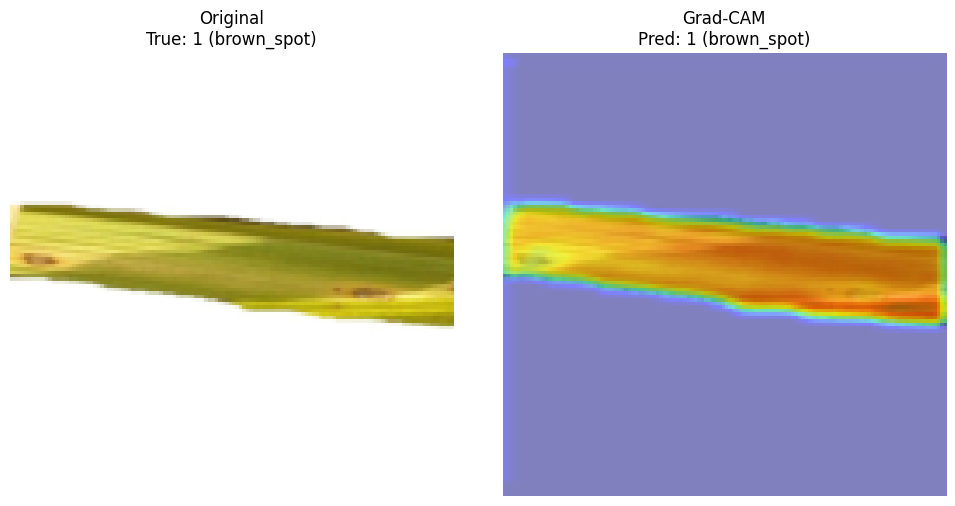

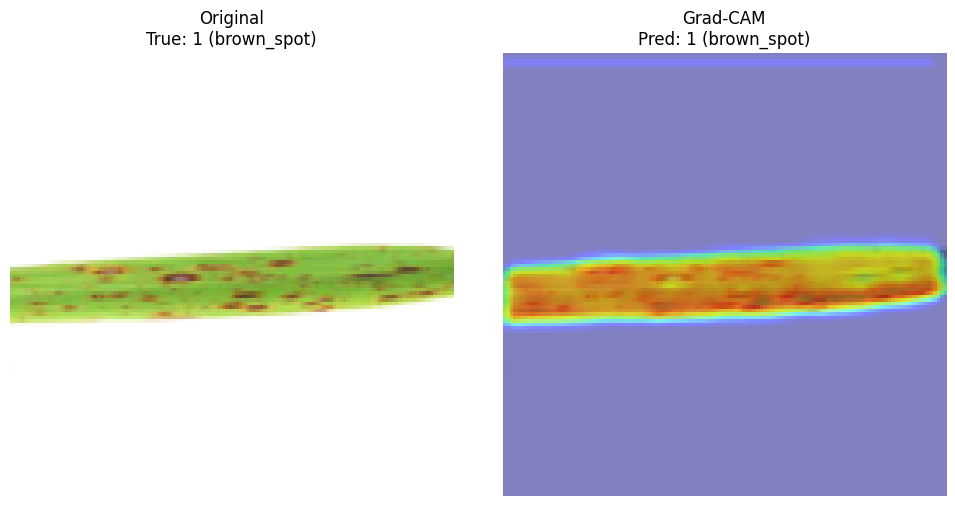

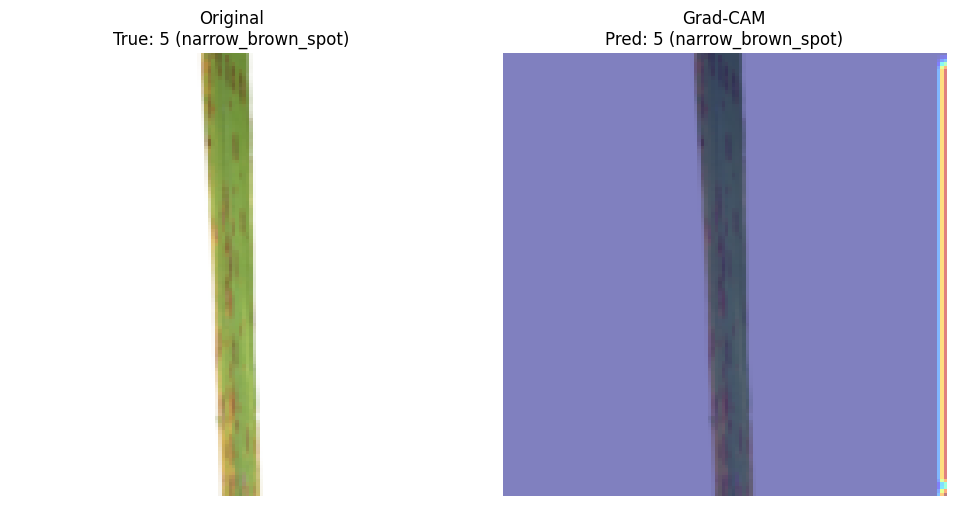

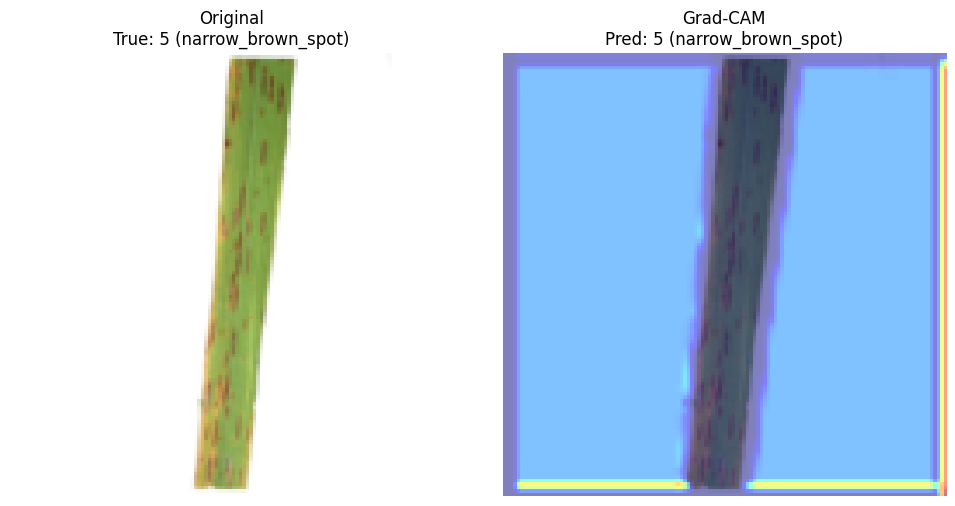

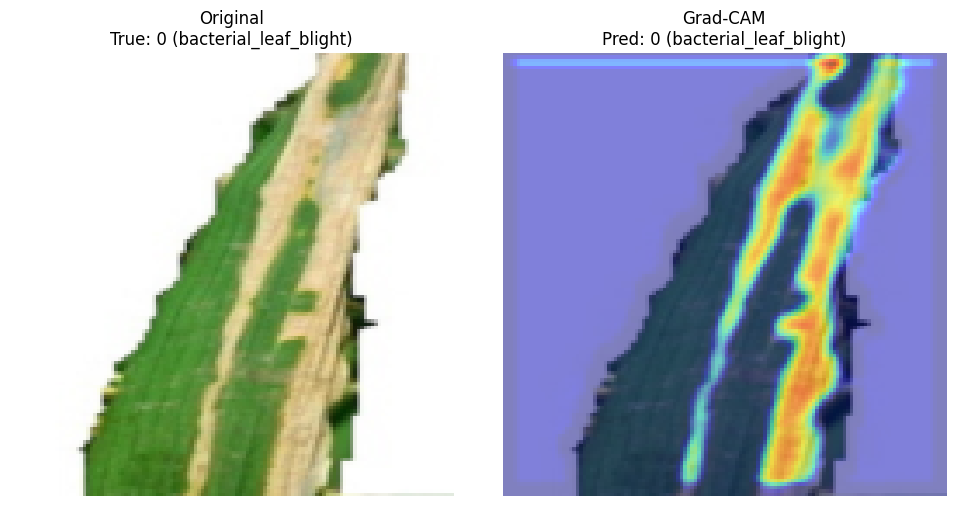

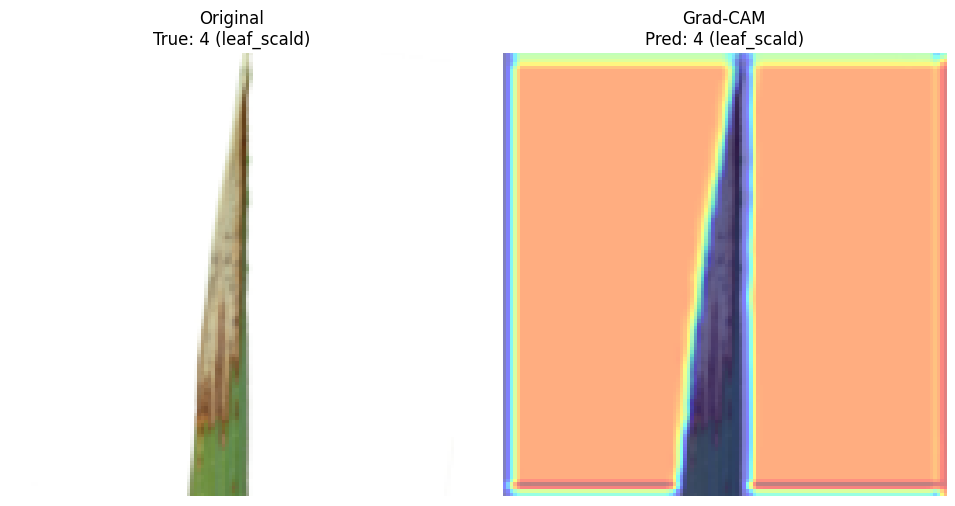

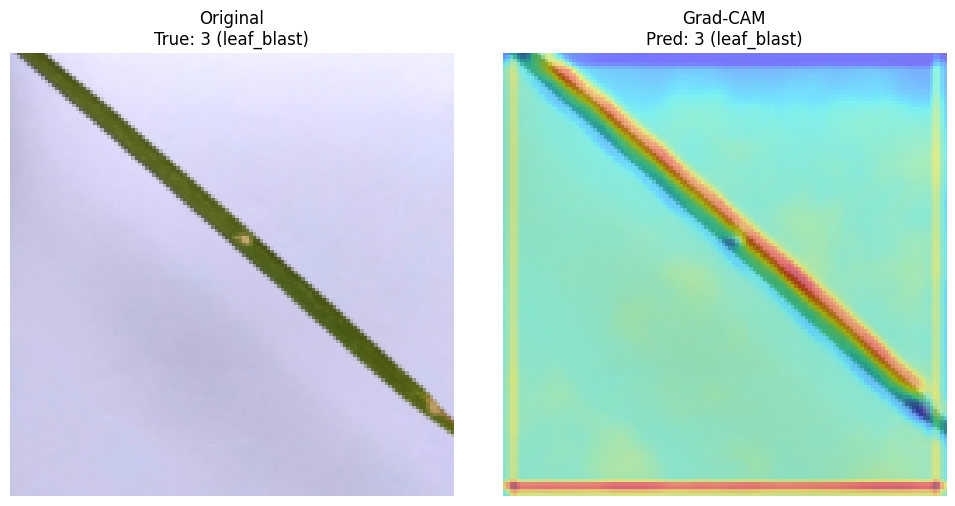

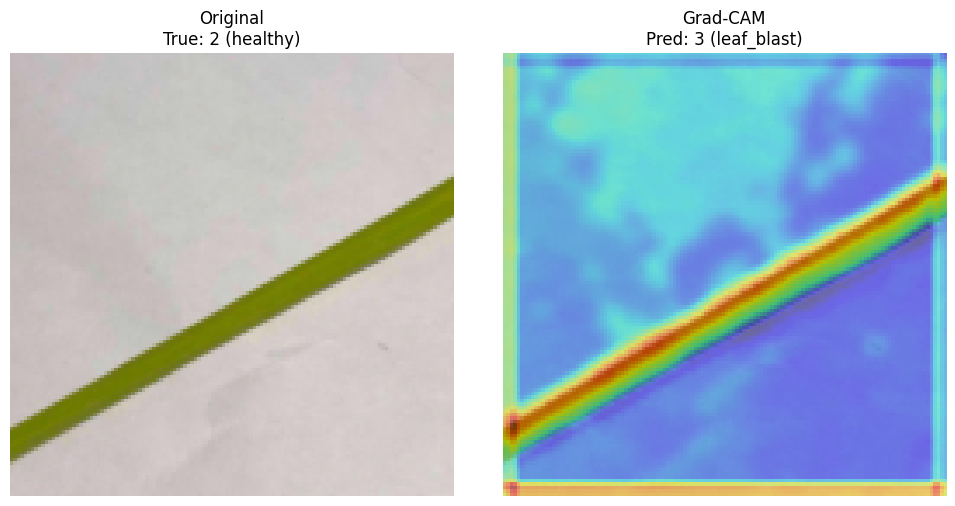

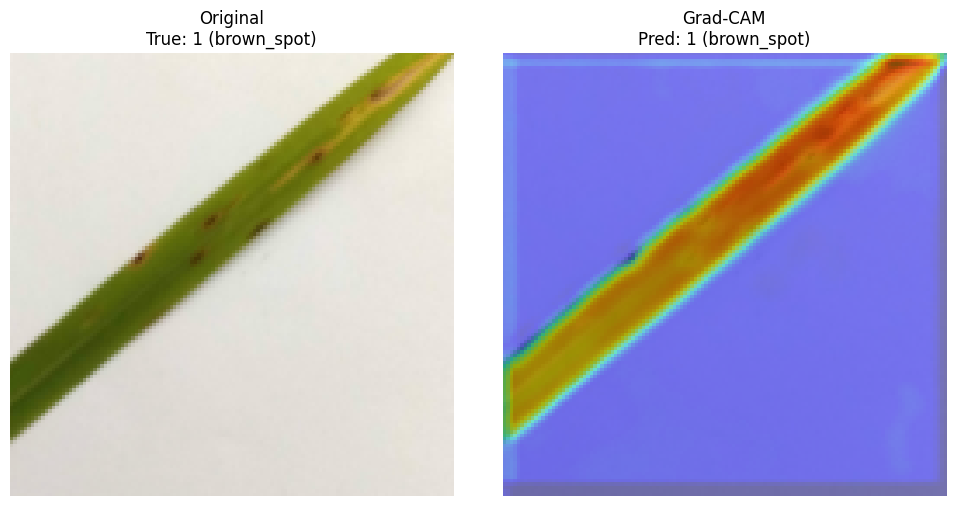

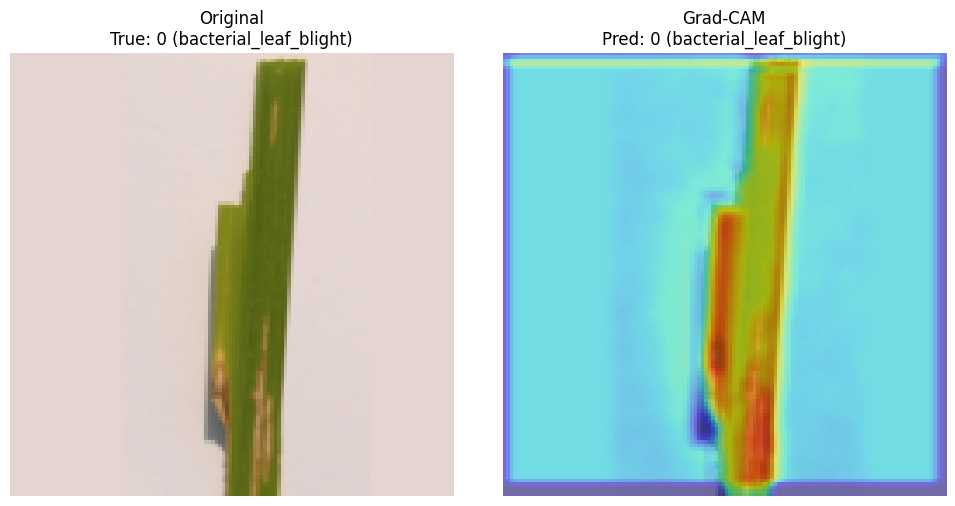

In [18]:
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Pick N random indices from the validation dataset
num_images = 20  # Change this to any number you want
random_indices = random.sample(range(len(val_dataset)), num_images)

# Set model to eval
model.eval()

# Loop through selected images
for idx in random_indices:
    img, true_label = val_dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)
    input_tensor.requires_grad_()

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax().item()

    # Generate Grad-CAM
    activation_map = cam_extractor(pred_class, output)[0]  # shape: (1, H, W)

    # Resize CAM to match image size
    cam = F.interpolate(activation_map.unsqueeze(0), size=img_size, mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().numpy()

    # Convert image for display
    original_img = to_pil_image(img)

    # Plot side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(original_img)
    axes[0].set_title(f"Original\nTrue: {true_label} ({list(train_dataset.label_map.keys())[true_label]})")
    axes[0].axis("off")

    axes[1].imshow(original_img)
    axes[1].imshow(cam, cmap='jet', alpha=0.5)
    axes[1].set_title(f"Grad-CAM\nPred: {pred_class} ({list(train_dataset.label_map.keys())[pred_class]})")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


Saliency-MAP

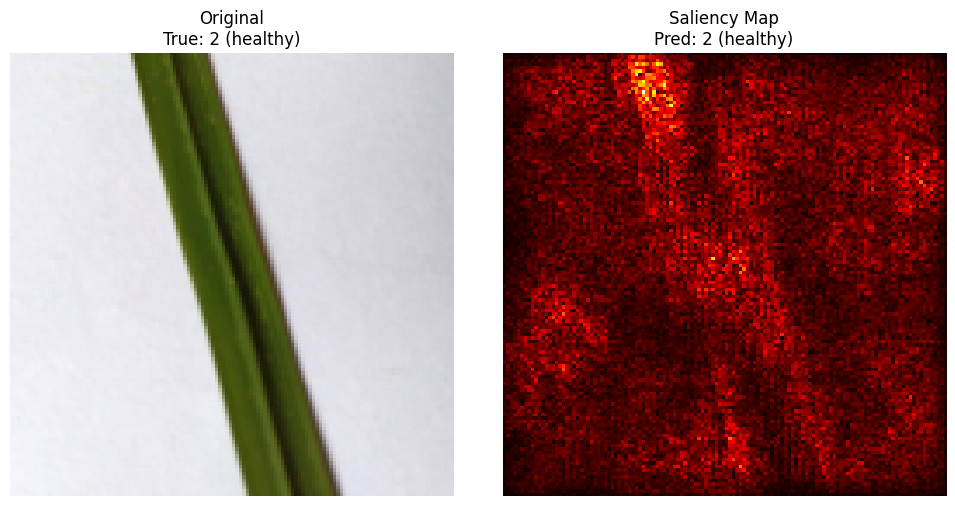

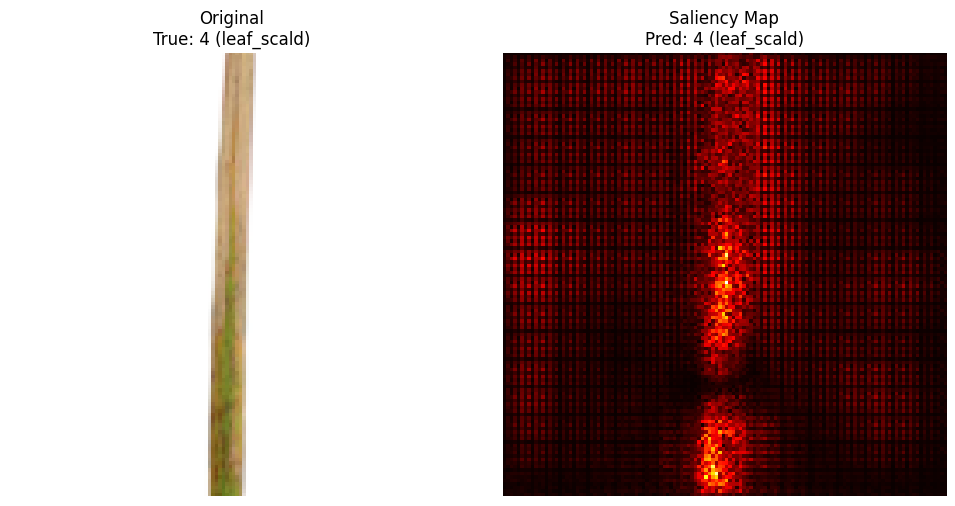

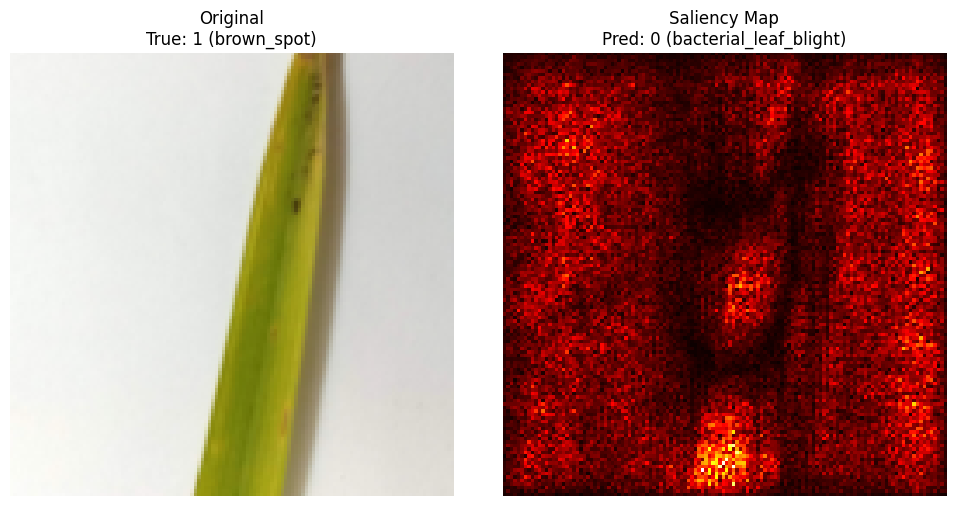

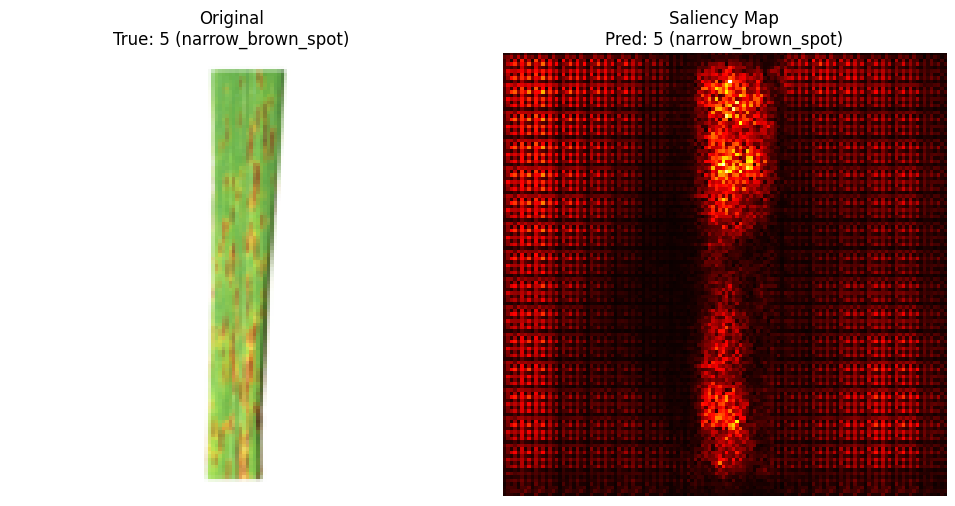

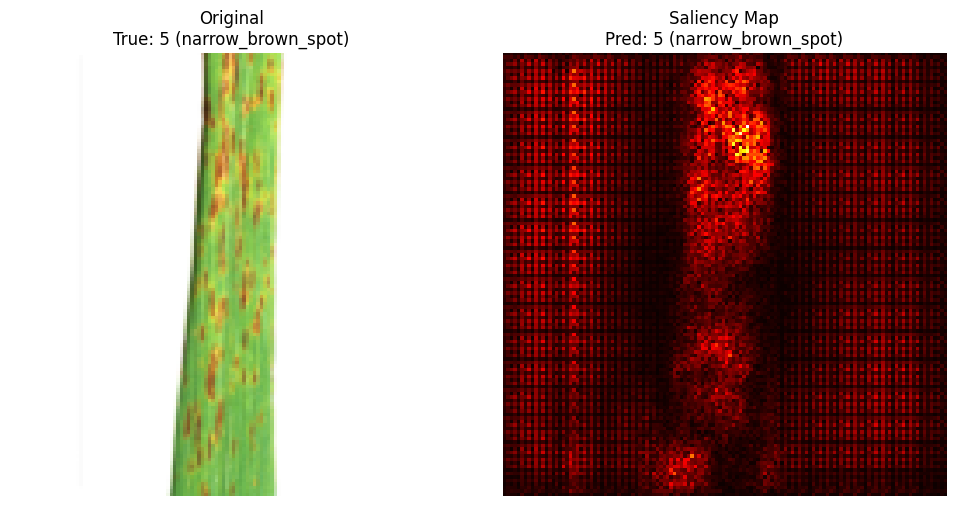

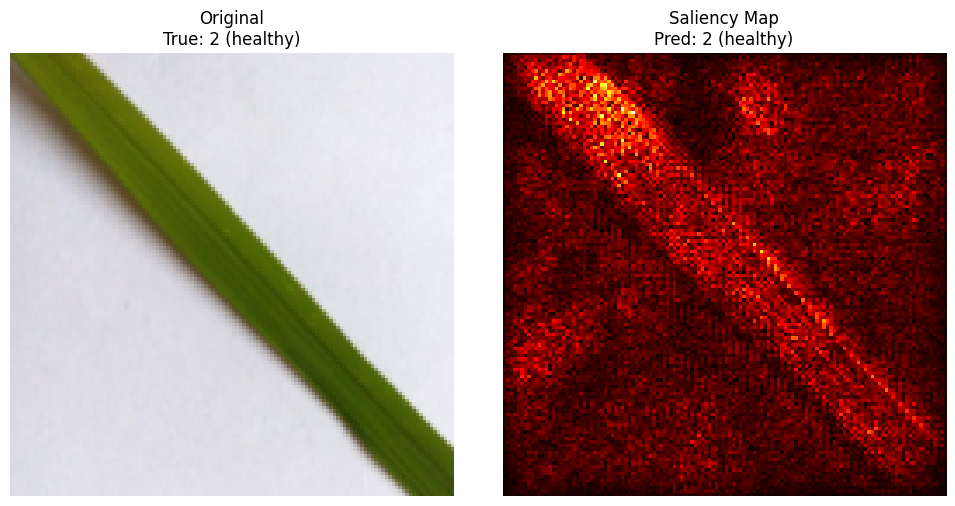

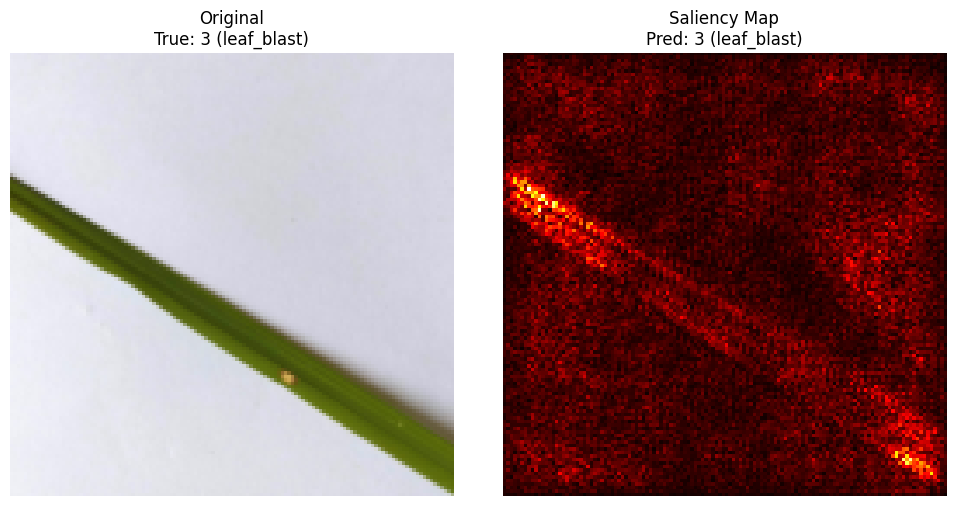

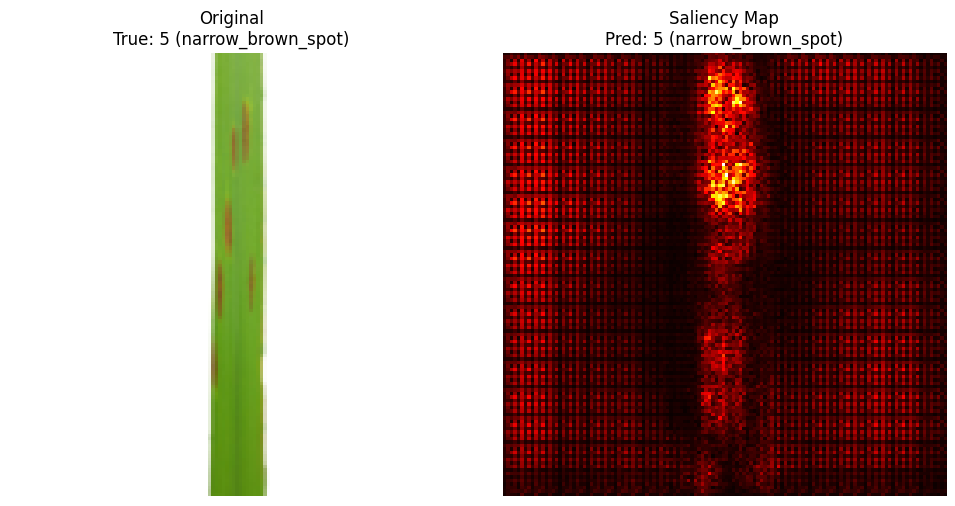

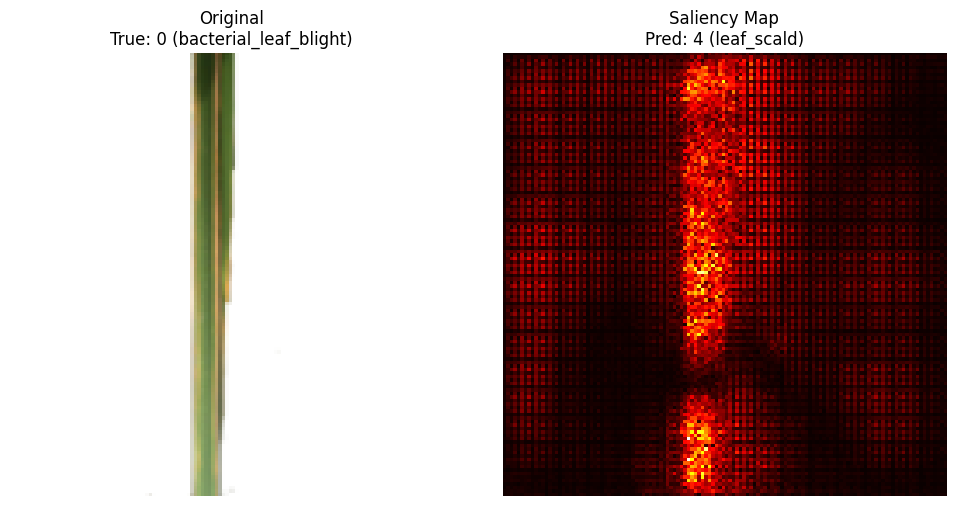

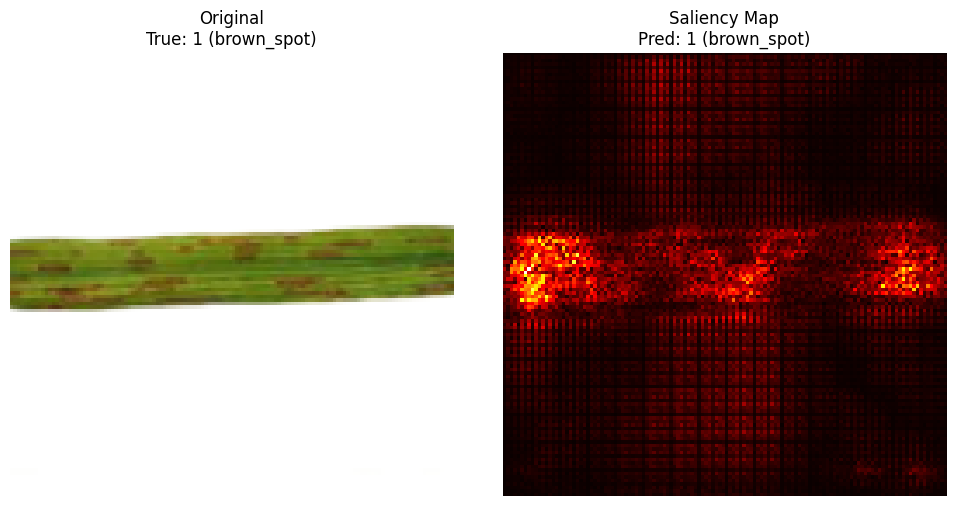

In [21]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import random

# Set model to eval
model.eval()

# Pick 5 random images from validation dataset
num_images = 10
indices = random.sample(range(len(val_dataset)), num_images)

for idx in indices:
    img, label = val_dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)
    input_tensor.requires_grad_()

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax()

    # Zero gradients and backprop from predicted class score
    model.zero_grad()
    output[0, pred_class].backward()

    # Saliency computation
    saliency = input_tensor.grad.data.abs().squeeze()  # shape: (3, H, W)
    saliency_map = saliency.max(dim=0)[0].cpu().numpy()  # shape: (H, W)

    # Convert to image
    original_img = to_pil_image(img)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_img)
    axes[0].set_title(f"Original\nTrue: {label} ({list(train_dataset.label_map.keys())[label]})")
    axes[0].axis("off")
    
    axes[1].imshow(saliency_map, cmap='hot')
    axes[1].set_title(f"Saliency Map\nPred: {pred_class.item()} ({list(train_dataset.label_map.keys())[pred_class.item()]})")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

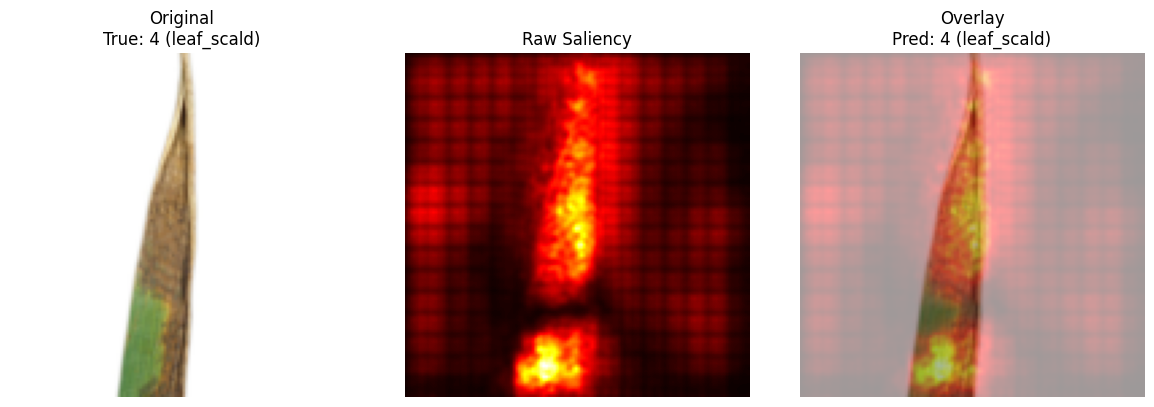

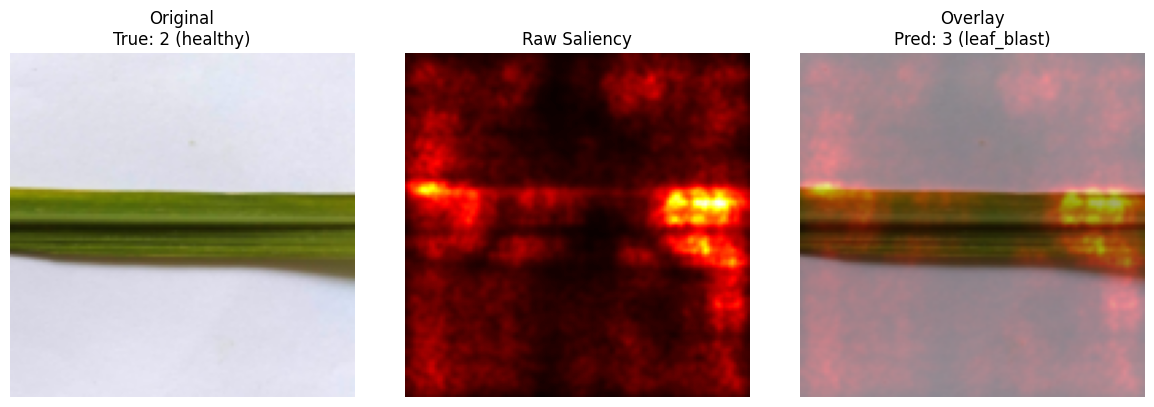

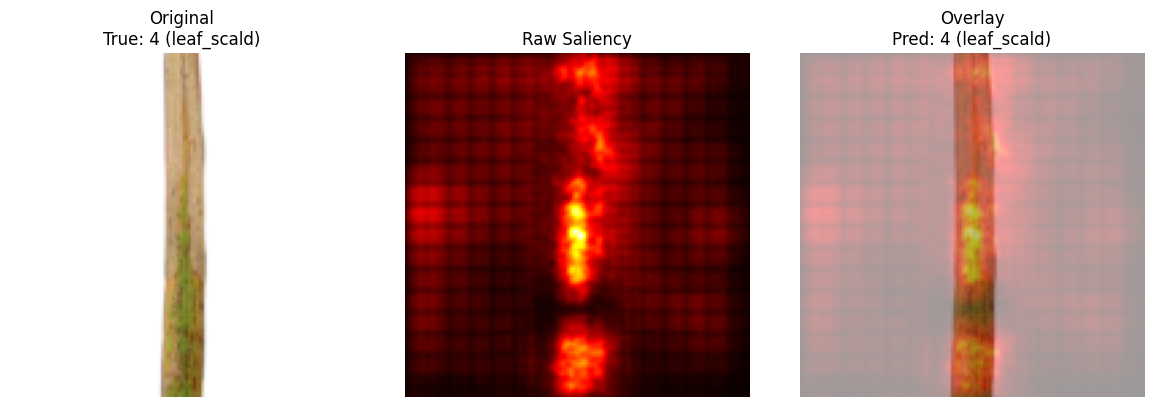

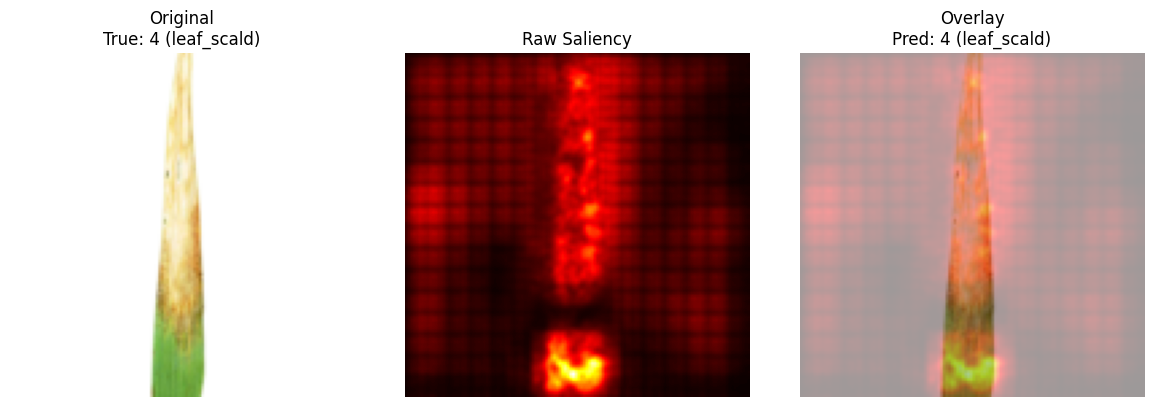

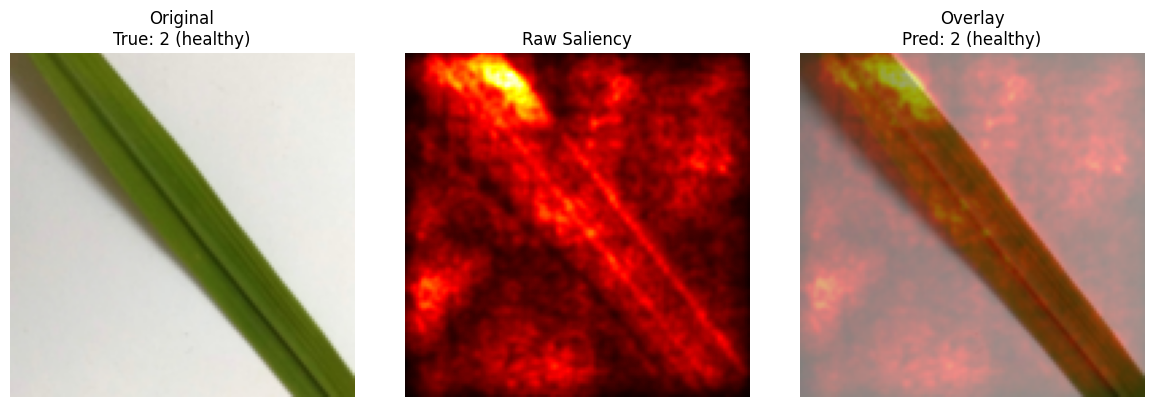

In [23]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image, to_tensor
from scipy.ndimage import gaussian_filter

model.eval()

indices = random.sample(range(len(val_dataset)), 5)

for idx in indices:
    img, label = val_dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)
    input_tensor.requires_grad_()

    # Forward pass
    output = model(input_tensor)
    pred_class = output.argmax()

    # Backward on predicted class
    model.zero_grad()
    output[0, pred_class].backward()

    # Raw saliency map
    saliency = input_tensor.grad.data.abs().squeeze()
    saliency_map = saliency.max(dim=0)[0].cpu().numpy()

    # Optional Gaussian smoothing
    saliency_map = gaussian_filter(saliency_map, sigma=1)

    # Normalize saliency
    saliency_map -= saliency_map.min()
    saliency_map /= saliency_map.max()

    # Convert original image
    original_img = to_pil_image(img)
    img_tensor = to_tensor(original_img)

    # Create heatmap
    heatmap = plt.get_cmap("hot")(saliency_map)[:, :, :3]  # Remove alpha
    heatmap_tensor = torch.tensor(heatmap).permute(2, 0, 1)

    # Overlay
    overlay = 0.6 * img_tensor + 0.4 * heatmap_tensor
    overlay = torch.clamp(overlay, 0, 1)

    # Plot all three
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(original_img)
    axes[0].set_title(f"Original\nTrue: {label} ({list(train_dataset.label_map.keys())[label]})")
    axes[0].axis("off")

    axes[1].imshow(saliency_map, cmap='hot')
    axes[1].set_title("Raw Saliency")
    axes[1].axis("off")

    axes[2].imshow(to_pil_image(overlay))
    axes[2].set_title(f"Overlay\nPred: {pred_class.item()} ({list(train_dataset.label_map.keys())[pred_class.item()]})")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
